In [55]:
import Pkg, Random
Pkg.add("PyCall")
Pkg.add("Gen")


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [56]:
using Gen, PyCall, Plots

Random.seed!(42)
torch = pyimport("torch")
nn = pyimport("torch.nn")
F = pyimport("torch.nn.functional")


PyObject <module 'torch.nn.functional' from '/Users/albin/.julia/conda/3/aarch64/lib/python3.10/site-packages/torch/nn/functional.py'>

In [57]:
@gen function burglar_model(chance)
    burglar ~ bernoulli(chance)

    if burglar
        alarm ~ bernoulli(0.9)
    else
        alarm ~ bernoulli(0.15)
    end

    if alarm
        john ~ bernoulli(0.6)
        mary ~ bernoulli(0.7)
    else
        john ~ bernoulli(0.3)
        mary ~ bernoulli(0.1)
    end

end;


In [58]:

function print_analytical_probabilities(chance)
    # Probabilities of burglar being present or not
    P_burglar = chance
    P_no_burglar = 1 - chance

    # Probabilities of alarm going off given burglar presence
    P_alarm_given_burglar = 0.9
    P_no_alarm_given_burglar = 0.1
    P_alarm_given_no_burglar = 0.15
    P_no_alarm_given_no_burglar = 0.85

    # Probabilities of John and Mary reacting to alarm
    P_john_given_alarm = 0.6
    P_john_given_no_alarm = 0.3
    P_mary_given_alarm = 0.7
    P_mary_given_no_alarm = 0.1

    # Define a helper function to calculate the conditional probabilities
    function P_AB_given_JM(john, mary)
        # Convert integer to boolean for calculations
        john_presence = john == 1
        mary_presence = mary == 1

        # Calculate probabilities of alarm and burglar given John and Mary's observations
        # Using Bayes' theorem and total probability theorem

        # Probability of John and Mary given alarm
        P_JM_given_alarm = (john_presence ? P_john_given_alarm : (1 - P_john_given_alarm)) *
                        (mary_presence ? P_mary_given_alarm : (1 - P_mary_given_alarm))

        # Probability of John and Mary given no alarm
        P_JM_given_no_alarm = (john_presence ? P_john_given_no_alarm : (1 - P_john_given_no_alarm)) *
                            (mary_presence ? P_mary_given_no_alarm : (1 - P_mary_given_no_alarm))

        # Total probability of John and Mary
        P_JM = (P_JM_given_alarm * P_alarm_given_burglar * P_burglar) +
            (P_JM_given_alarm * P_alarm_given_no_burglar * P_no_burglar) +
            (P_JM_given_no_alarm * P_no_alarm_given_burglar * P_burglar) +
            (P_JM_given_no_alarm * P_no_alarm_given_no_burglar * P_no_burglar)

        # Probability of Alarm and Burglar given John and Mary
        P_alarm_and_burglar_given_JM = (P_JM_given_alarm * P_alarm_given_burglar * P_burglar) / P_JM
        P_alarm_and_no_burglar_given_JM = (P_JM_given_alarm * P_alarm_given_no_burglar * P_no_burglar) / P_JM
        P_no_alarm_and_burglar_given_JM = (P_JM_given_no_alarm * P_no_alarm_given_burglar * P_burglar) / P_JM
        P_no_alarm_and_no_burglar_given_JM = (P_JM_given_no_alarm * P_no_alarm_given_no_burglar * P_no_burglar) / P_JM

        # Combine the probabilities for the final output
        P_burglar_given_JM = P_alarm_and_burglar_given_JM + P_no_alarm_and_burglar_given_JM
        P_alarm_given_JM = P_alarm_and_burglar_given_JM + P_alarm_and_no_burglar_given_JM

        return P_alarm_given_JM, P_burglar_given_JM
    end


    # Iterate over the combinations of John and Mary's presence
    for (john, mary) in [(0, 0), (0, 1), (1, 0), (1, 1)]
        # Use the helper function to calculate conditional probabilities
        P_alarm_given_JM, P_burglar_given_JM = P_AB_given_JM(john, mary)
        println("P(A, B | J=$john, M=$mary) = (B: $(round(P_burglar_given_JM, digits=2)), A: $(round(P_alarm_given_JM, digits=2)))")
    end
end



# Print header
println("P(A = Alarm, B = Burglar | J = John, M = Mary)")
println("Analystical posterior:")
print_analytical_probabilities(chance)


P(A = Alarm, B = Burglar | J = John, M = Mary)
Analystical posterior:
P(A, B | J=0, M=0) = (B: 0.03, A: 0.05)
P(A, B | J=0, M=1) = (B: 0.22, A: 0.54)
P(A, B | J=1, M=0) = (B: 0.08, A: 0.16)
P(A, B | J=1, M=1) = (B: 0.32, A: 0.8)


In [59]:


@pydef mutable struct NeuralProposal <: nn.Module
    function __init__(self, num_in, num_out, hidden_size=25)
        # Note the use of pybuiltin(:super): built in Python functions
        # like `super` or `str` or `slice` are all accessed using
        # `pybuiltin`.
        pybuiltin(:super)(NeuralProposal, self).__init__()
        self.fc1 = nn.Linear(num_in, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_out)
    end

    function forward(self, x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # make sure the output is between 0 and 1
        x = F.sigmoid(x)
        return x
    end
end




# Define a function to get the output from the network and format it
function predict_and_format(john, mary)
    # Convert John and Mary's presence to a tensor input for the network
    input_tensor = torch.tensor([john, mary], dtype=torch.float32)
    # Get the network's output, detach from the current graph and convert to a NumPy array
    output = network(input_tensor).detach().numpy()
    # Round the output probabilities to two decimals and return
    return round.(output, digits=2)
end

# input is tuple (john, mary)
# output is parameters for (burglar, alarm)
network = NeuralProposal(2, 2)

println("Untrained NN proposal:")
# Iterate over the combinations of John and Mary's presence
for (john, mary) in [(0, 0), (0, 1), (1, 0), (1, 1)]
    # Use the function to get the formatted output
    output = predict_and_format(john, mary)
    println("P(A, B | J=$john, M=$mary) ≈ (B: $(output[1]), A: $(output[2]))")
end


Untrained NN proposal:


P(A, B | J=0, M=0) ≈ (B: 0.4, A: 0.55)
P(A, B | J=0, M=1) ≈ (B: 0.38, A: 0.57)
P(A, B | J=1, M=0) ≈ (B: 0.35, A: 0.55)
P(A, B | J=1, M=1) ≈ (B: 0.3, A: 0.54)


In [60]:
@gen function simple_neural_proposal(trace)
    parameters = network(torch.tensor([trace[:john], trace[:mary]], dtype=torch.float32))
    # extract float values from the PyTorch tensor
    b_param = parameters[1].item()
    a_param = parameters[2].item()

    burglar ~ bernoulli(b_param)
    alarm ~ bernoulli(a_param)
end;


function block_resimulation_burglar(john,mary, budget=1000, chance=0.5)
    observations = Gen.choicemap()
    observations[:john] = john
    observations[:mary] = mary
    (tr, ) = Gen.generate(burglar_model, (chance,), observations)
    for iter=1:budget
        (tr, ) = mh(tr, select(:burglar, :alarm))
    end
    tr
end;

function nn_resimulation_burglar(john,mary, budget=1000, chance=0.5)
    observations = Gen.choicemap()
    observations[:john] = john
    observations[:mary] = mary
    (tr, ) = Gen.generate(burglar_model, (chance,), observations)
    for iter=1:budget
        (tr, ) = mh(tr, simple_neural_proposal, ())
    end
    tr
end;


function make_constraints_burglar(trace)
    choices = Gen.get_choices(trace)
    constraints = choicemap()
    constraints[:john] = choices[:john]
    constraints[:mary] = choices[:mary]
    constraints[:burglar] = choices[:burglar]
    constraints[:alarm] = choices[:alarm]
    return constraints
end


make_constraints_burglar (generic function with 1 method)

In [61]:
# how often does it get it right?
function accuracy(model, data, inference, budget=1000, chance=0.5)
    correct = 0
    for trace in data
        c = make_constraints_burglar(trace)
        tr = inference(c[:john],c[:mary], budget, chance)
        choices=Gen.get_choices(tr)
        if choices[:burglar] == c[:burglar] && choices[:alarm] == c[:alarm]
            correct += 1
        end
    end
    return correct / length(data)
end

# generate training data by sampling from the model:
function generate_data(model, n, chance)
    data = []
    for i=1:n
        (trace, _) = Gen.generate(model, (chance,), choicemap())
        push!(data, trace)
    end
    return data
end


generate_data (generic function with 1 method)

In [62]:
chance = 0.1
inference_budget = 1
test_budget = 10000
test_data = generate_data(burglar_model, test_budget, chance)
no_proposal_acc = accuracy(burglar_model, test_data, block_resimulation_burglar, inference_budget, chance)
untrainted_acc = accuracy(burglar_model, test_data, nn_resimulation_burglar, inference_budget, chance)


0.6488

In [63]:
DataLoader = torch.utils.data.DataLoader

# convert the data into a format that PyTorch can use
train_data_size = 100000
train_data = generate_data(burglar_model, train_data_size, chance)

# convert data to tensors and zip them
data_tensors = [(torch.tensor([trace[:john], trace[:mary]], dtype=torch.float32),
                 torch.tensor([trace[:burglar], trace[:alarm]], dtype=torch.float32)) for trace in train_data]
data_tensors


100000-element Vector{Tuple{PyObject, PyObject}}:
 (PyObject tensor([0., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([0., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([0., 0.]), PyObject tensor([1., 0.]))
 (PyObject tensor([1., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([1., 1.]), PyObject tensor([0., 0.]))
 (PyObject tensor([0., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([1., 1.]), PyObject tensor([0., 1.]))
 (PyObject tensor([1., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([0., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([1., 1.]), PyObject tensor([0., 0.]))
 ⋮
 (PyObject tensor([0., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([0., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([0., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([0., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([1., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([0., 1.]), PyObject tensor([0., 0.]))
 (PyObject tensor([0., 1.]), PyObject tensor([0., 1

1: loss: 0.5482608354091645


2: loss: 0.44743911385536195


3: loss: 0.38436339169740674


4: loss: 0.3407198345661163


5: loss: 0.3237710329890251


6: loss: 0.3190985134243965


7: loss: 0.31796898365020754


8: loss: 0.31767440229654315


9: loss: 0.317568279504776


10: loss: 0.31751523673534393
Done training


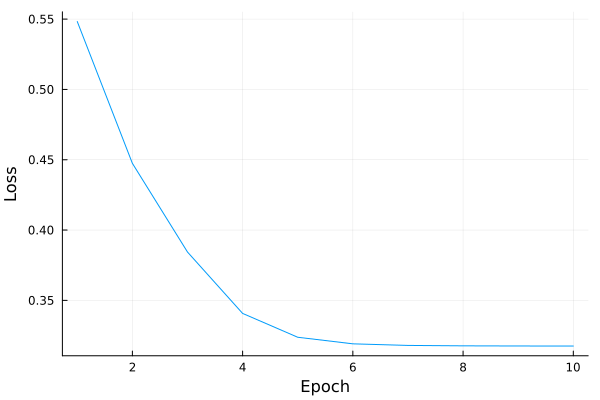

In [64]:
# create a DataLoader with batch size
batch_size = 1000
data_loader = DataLoader(data_tensors, batch_size=batch_size, shuffle=true)

# the loss function is the negative log likelihood
loss_fn = nn.BCELoss()

# the optimizer is the algorithm that updates the parameters
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

# we will train for 100 epochs
epochs = 10

mean_losses = []
for epoch=1:epochs
    losses = []
    for (x, y) in data_loader
        # compute the output of the network
        y_pred = network(x)

        # compute the loss
        loss = loss_fn(y_pred, y)
        # add loss
        push!(losses, loss.item())

        # zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # run the backward pass
        loss.backward()

        # update the parameters
        optimizer.step()
    end

    mean_loss = sum(losses) / length(losses)
    push!(mean_losses, mean_loss)
    println(epoch, ": loss: ", mean_loss)
end

println("Done training")
# plot loss
plot(mean_losses, xlabel="Epoch", ylabel="Loss", legend=false)


In [65]:
println("Trained NN proposal:")
# Iterate over the combinations of John and Mary's presence
for (john, mary) in [(0, 0), (0, 1), (1, 0), (1, 1)]
    # Use the function to get the formatted output
    output = predict_and_format(john, mary)
    println("P(A, B | J=$john, M=$mary) ≈ (B: $(output[1]), A: $(output[2]))")
end

println("Analytical:")
print_analytical_probabilities(chance)


Trained NN proposal:
P(A, B | J=0, M=0) ≈ (B: 0.04, A: 0.05)
P(A, B | J=0, M=1) ≈ (B: 0.21, A: 0.55)
P(A, B | J=1, M=0) ≈ (B: 0.07, A: 0.16)
P(A, B | J=1, M=1) ≈ (B: 0.33, A: 0.8)
Analytical:
P(A, B | J=0, M=0) = (B: 0.03, A: 0.05)
P(A, B | J=0, M=1) = (B: 0.22, A: 0.54)
P(A, B | J=1, M=0) = (B: 0.08, A: 0.16)
P(A, B | J=1, M=1) = (B: 0.32, A: 0.8)


In [66]:
trained_acc = accuracy(burglar_model, test_data, nn_resimulation_burglar, inference_budget, chance)

println("No proposal accuracy: ", no_proposal_acc)
println("Untrained proposal accuracy: ", untrainted_acc)
println("Trained proposal accuracy: ", trained_acc)


No proposal accuracy: 0.6916
Untrained proposal accuracy: 0.6488
Trained proposal accuracy: 0.6732
